<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_09/01_Supervised_Contrastive_Learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Setup and Dataset Preparation

In [2]:
!pip install tensorflow-addons

In [5]:
!pip install -q tensorflow==2.15.0 keras==2.15.0
!pip install -q tensorflow-addons==0.22.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 371.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.15.0 which is incompatible.
te

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

In [2]:
# Imports
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Seed setup for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Plot settings
%matplotlib inline
sns.set(style='whitegrid')

# Colab-specific: autoreload for code updates
%load_ext autoreload
%autoreload 2


In [4]:
# Global configuration
EPOCHS = 20
DATA = 'fashion_mnist'  # or 'mnist'
NORMALIZE_EMBEDDING = True
N_DATA_TRAIN = 60000
BATCH_SIZE = 1024  # Pretraining
BATCH_SIZE_FINETUNE = 32  # Fine-tuning
PROJECTION_DIM = 256
ACTIVATION = 'leaky_relu'
LR = 0.5  # For stage 1
WRITE_SUMMARY = False

# Make directory to store logs (if needed)
os.makedirs("logs", exist_ok=True)


In [5]:
# Load dataset
if DATA == 'mnist':
    mnist = tf.keras.datasets.mnist
else:
    mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Flatten and convert
x_train = x_train.reshape(-1, 28*28).astype(np.float32)
x_test = x_test.reshape(-1, 28*28).astype(np.float32)

print(f"Train shape: {x_train.shape}, Test shape: {x_test.shape}")


4422102/4422102 [==============================] - 0s 0us/step
Train shape: (60000, 784), Test shape: (10000, 784)


## Step 2: Build and Train a Baseline CNN Classifier with Softmax (Cross-Entropy Loss)

In [6]:
# Simulate training data regime
shuffle_idx = np.arange(x_train.shape[0])
np.random.shuffle(shuffle_idx)

x_train = x_train[shuffle_idx][:N_DATA_TRAIN]
y_train = y_train[shuffle_idx][:N_DATA_TRAIN]

print(f"Final training shape: {x_train.shape}, {y_train.shape}")

# Wrap as tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(BATCH_SIZE)
train_ds2 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(BATCH_SIZE_FINETUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)


Final training shape: (60000, 784), (60000,)


In [7]:
from tensorflow.keras import layers, models

# Encoder network (backbone)
class Encoder(tf.keras.Model):
    def __init__(self, normalize=True, activation='relu'):
        super().__init__()
        self.dense1 = layers.Dense(512)
        self.dense2 = layers.Dense(256)
        self.activation = tf.keras.activations.get(activation)
        self.normalize = normalize

    def call(self, x):
        x = self.activation(self.dense1(x))
        x = self.activation(self.dense2(x))
        if self.normalize:
            x = tf.math.l2_normalize(x, axis=1)
        return x

# Projector network for contrastive loss
class Projector(tf.keras.Model):
    def __init__(self, proj_dim=128, normalize=True, activation='relu'):
        super().__init__()
        self.dense1 = layers.Dense(512)
        self.dense2 = layers.Dense(proj_dim)
        self.activation = tf.keras.activations.get(activation)
        self.normalize = normalize

    def call(self, x):
        x = self.activation(self.dense1(x))
        x = self.dense2(x)
        if self.normalize:
            x = tf.math.l2_normalize(x, axis=1)
        return x

# Softmax classifier head for stage 2
class SoftmaxPred(tf.keras.Model):
    def __init__(self, n_classes=10):
        super().__init__()
        self.linear = layers.Dense(n_classes)

    def call(self, x):
        return self.linear(x)


## Step 3: Supervised Contrastive Learning Model (SCL)

In [8]:
import tensorflow as tf

# Supervised NT-Xent Loss (Khosla et al., 2020)
def supervised_nt_xent_loss(features, labels, temperature=0.1):
    features = tf.math.l2_normalize(features, axis=1)
    similarity_matrix = tf.matmul(features, features, transpose_b=True)

    logits = similarity_matrix / temperature
    labels = tf.reshape(labels, (-1, 1))
    mask = tf.equal(labels, tf.transpose(labels))

    # Remove self-contrast
    logits_mask = tf.cast(~tf.eye(tf.shape(labels)[0], dtype=tf.bool), tf.float32)
    mask = tf.cast(mask, tf.float32) * logits_mask

    # Normalize probabilities
    exp_logits = tf.exp(logits) * logits_mask
    log_prob = logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True) + 1e-9)

    # Mean log-likelihood over positive pairs
    mean_log_prob_pos = tf.reduce_sum(mask * log_prob, axis=1) / tf.reduce_sum(mask, axis=1)
    loss = -tf.reduce_mean(mean_log_prob_pos)
    return loss

# Multiclass N-Pairs Loss (Sohn 2016)
def multiclass_npairs_loss(features, labels):
    features = tf.math.l2_normalize(features, axis=1)
    similarity_matrix = tf.matmul(features, features, transpose_b=True)

    labels = tf.reshape(labels, (-1, 1))
    mask = tf.equal(labels, tf.transpose(labels))

    labels_mask = tf.cast(mask, tf.float32)
    logits = similarity_matrix
    logits_mask = tf.cast(~tf.eye(tf.shape(labels)[0], dtype=tf.bool), tf.float32)

    exp_logits = tf.exp(logits) * logits_mask
    log_prob = logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True) + 1e-9)

    mean_log_prob_pos = tf.reduce_sum(labels_mask * log_prob, axis=1) / tf.reduce_sum(labels_mask, axis=1)
    loss = -tf.reduce_mean(mean_log_prob_pos)
    return loss


## Step 4: Stage 1 — Train Encoder + Projector using Supervised Contrastive Loss

In [9]:
#  Instantiate encoder and projector
encoder = Encoder(normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)
projector = Projector(PROJECTION_DIM, normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)

# Optimizer for stage 1
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

# Metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')


In [10]:
@tf.function
def train_step_ntxent(x, y):
    with tf.GradientTape() as tape:
        r = encoder(x, training=True)
        z = projector(r, training=True)
        loss = supervised_nt_xent_loss(z, y, temperature=0.1)
    grads = tape.gradient(loss, encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(grads, encoder.trainable_variables + projector.trainable_variables))
    train_loss(loss)

@tf.function
def train_step_npair(x, y):
    with tf.GradientTape() as tape:
        r = encoder(x, training=True)
        z = projector(r, training=True)
        loss = multiclass_npairs_loss(z, y)
    grads = tape.gradient(loss, encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(grads, encoder.trainable_variables + projector.trainable_variables))
    train_loss(loss)

@tf.function
def test_step(x, y, loss_fn):
    r = encoder(x, training=False)
    z = projector(r, training=False)
    loss = loss_fn(z, y)
    test_loss(loss)


In [11]:
# Choose loss function here
loss_fn = supervised_nt_xent_loss  # or multiclass_npairs_loss
train_fn = train_step_ntxent       # or train_step_npair

for epoch in range(EPOCHS):
    train_loss.reset_states()
    test_loss.reset_states()

    for x_batch, y_batch in train_ds:
        train_fn(x_batch, y_batch)

    for x_batch, y_batch in test_ds:
        test_step(x_batch, y_batch, loss_fn)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss.result():.4f}, Test Loss: {test_loss.result():.4f}")


Epoch 1, Train Loss: 6.0614, Test Loss: 5.8876
Epoch 2, Train Loss: 5.8013, Test Loss: 5.7517
Epoch 3, Train Loss: 5.6893, Test Loss: 5.6488
Epoch 4, Train Loss: 5.5797, Test Loss: 5.5266
Epoch 5, Train Loss: 5.4605, Test Loss: 5.4398
Epoch 6, Train Loss: 5.3679, Test Loss: 5.3586
Epoch 7, Train Loss: 5.3110, Test Loss: 5.3358
Epoch 8, Train Loss: 5.2754, Test Loss: 5.3025
Epoch 9, Train Loss: 5.2448, Test Loss: 5.2830
Epoch 10, Train Loss: 5.2254, Test Loss: 5.3116
Epoch 11, Train Loss: 5.2106, Test Loss: 5.2621
Epoch 12, Train Loss: 5.1934, Test Loss: 5.2721
Epoch 13, Train Loss: 5.1764, Test Loss: 5.2507
Epoch 14, Train Loss: 5.1658, Test Loss: 5.2563
Epoch 15, Train Loss: 5.1493, Test Loss: 5.2308
Epoch 16, Train Loss: 5.1257, Test Loss: 5.2258
Epoch 17, Train Loss: 5.1277, Test Loss: 5.2304
Epoch 18, Train Loss: 5.1101, Test Loss: 5.2271
Epoch 19, Train Loss: 5.1002, Test Loss: 5.2271
Epoch 20, Train Loss: 5.0914, Test Loss: 5.2131


In [12]:
# Project train and test data
x_tr_proj = projector(encoder(x_train, training=False)).numpy()
x_te_proj = projector(encoder(x_test, training=False)).numpy()

print(f"Train projected shape: {x_tr_proj.shape}, Test projected shape: {x_te_proj.shape}")


Train projected shape: (60000, 256), Test projected shape: (10000, 256)


In [13]:
from sklearn.decomposition import PCA

# PCA on projected embeddings
pca_proj = PCA(n_components=2)
x_te_proj_pca = pca_proj.fit_transform(x_te_proj)

# PCA on original raw data
pca_raw = PCA(n_components=2)
x_te_pca = pca_raw.fit_transform(x_test)


In [14]:
from sklearn.decomposition import PCA

# PCA on projected embeddings
pca_proj = PCA(n_components=2)
x_te_proj_pca = pca_proj.fit_transform(x_te_proj)

# PCA on original raw data
pca_raw = PCA(n_components=2)
x_te_pca = pca_raw.fit_transform(x_test)


## Step 5: Visualize Encoder + Projector Embeddings (PCA & Plots)

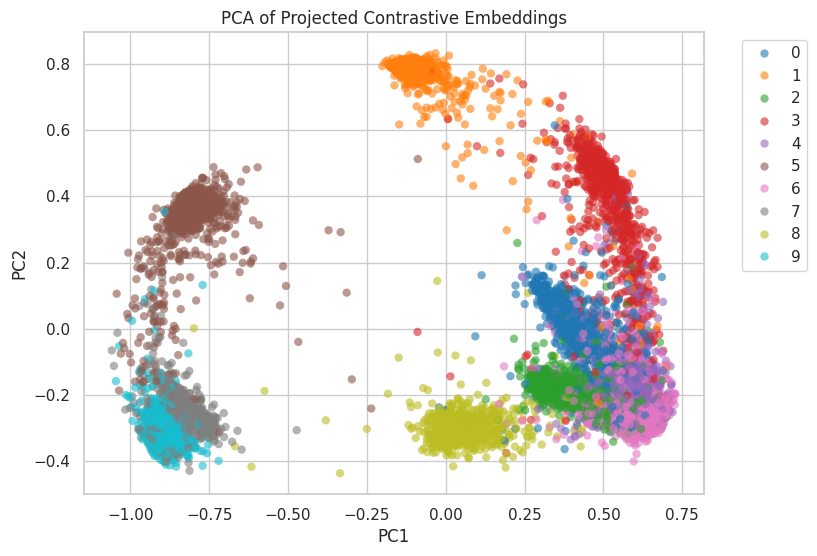

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to DataFrame for plotting
df_proj = pd.DataFrame(x_te_proj_pca, columns=['PC1', 'PC2'])
df_proj['label'] = y_test

plt.figure(figsize=(8,6))
ax = sns.scatterplot(x="PC1", y="PC2", hue="label", palette="tab10", data=df_proj, alpha=0.6, linewidth=0)
ax.set_title("PCA of Projected Contrastive Embeddings")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


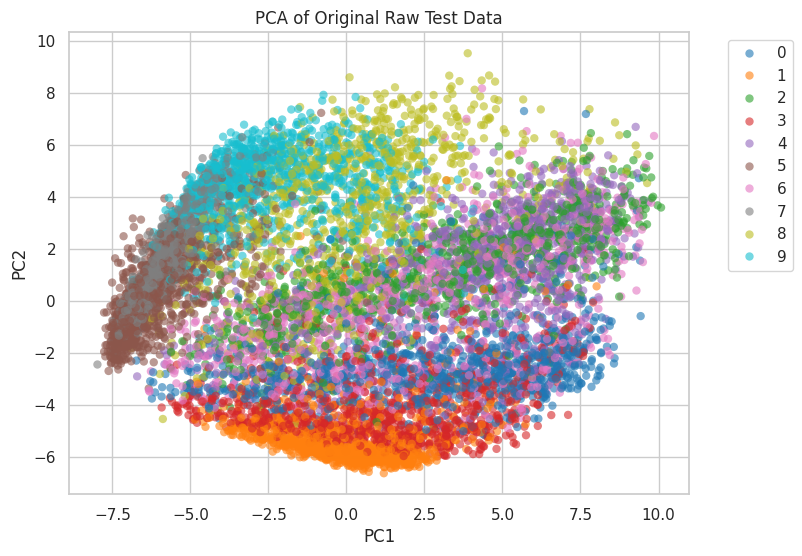

In [16]:
df_raw = pd.DataFrame(x_te_pca, columns=['PC1', 'PC2'])
df_raw['label'] = y_test

plt.figure(figsize=(8,6))
ax = sns.scatterplot(x="PC1", y="PC2", hue="label", palette="tab10", data=df_raw, alpha=0.6, linewidth=0)
ax.set_title("PCA of Original Raw Test Data")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## Step 6: Train Softmax Classifier on Frozen Encoder

In [17]:
# Softmax classifier on top of frozen encoder
softmax = SoftmaxPred(n_classes=10)

# Freeze encoder
encoder.trainable = False

# Optimizer for classifier training
optimizer2 = tf.keras.optimizers.Adam()

# Metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

# Loss function
crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


In [18]:
@tf.function
def train_step_classifier(x, y):
    with tf.GradientTape() as tape:
        r = encoder(x, training=False)
        logits = softmax(r, training=True)
        loss = crossentropy(y, logits)
    grads = tape.gradient(loss, softmax.trainable_variables)
    optimizer2.apply_gradients(zip(grads, softmax.trainable_variables))
    train_loss(loss)
    train_acc(y, logits)

@tf.function
def test_step_classifier(x, y):
    r = encoder(x, training=False)
    logits = softmax(r, training=False)
    loss = crossentropy(y, logits)
    test_loss(loss)
    test_acc(y, logits)


In [19]:
EPOCHS_STAGE2 = 20

for epoch in range(EPOCHS_STAGE2):
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for x_batch, y_batch in train_ds2:
        train_step_classifier(x_batch, y_batch)

    for x_batch, y_batch in test_ds:
        test_step_classifier(x_batch, y_batch)

    print(f"Epoch {epoch+1}, Train Acc: {train_acc.result()*100:.2f}%, Test Acc: {test_acc.result()*100:.2f}%")


Epoch 1, Train Acc: 86.32%, Test Acc: 86.90%
Epoch 2, Train Acc: 89.86%, Test Acc: 87.28%
Epoch 3, Train Acc: 90.29%, Test Acc: 87.58%
Epoch 4, Train Acc: 90.59%, Test Acc: 87.73%
Epoch 5, Train Acc: 90.77%, Test Acc: 87.79%
Epoch 6, Train Acc: 90.90%, Test Acc: 87.84%
Epoch 7, Train Acc: 91.01%, Test Acc: 87.92%
Epoch 8, Train Acc: 91.07%, Test Acc: 87.93%
Epoch 9, Train Acc: 91.14%, Test Acc: 87.92%
Epoch 10, Train Acc: 91.20%, Test Acc: 87.94%
Epoch 11, Train Acc: 91.25%, Test Acc: 87.96%
Epoch 12, Train Acc: 91.31%, Test Acc: 87.95%
Epoch 13, Train Acc: 91.35%, Test Acc: 87.96%
Epoch 14, Train Acc: 91.39%, Test Acc: 87.94%
Epoch 15, Train Acc: 91.36%, Test Acc: 87.98%
Epoch 16, Train Acc: 91.45%, Test Acc: 87.98%
Epoch 17, Train Acc: 91.47%, Test Acc: 87.96%
Epoch 18, Train Acc: 91.46%, Test Acc: 87.97%
Epoch 19, Train Acc: 91.51%, Test Acc: 87.95%
Epoch 20, Train Acc: 91.48%, Test Acc: 87.93%


##  Step 7: Final Evaluation & Visualization

In [23]:
print(f"\n Final Test Accuracy (Softmax on Contrastive Embeddings): {test_acc.result().numpy()*100:.2f}%")


 Final Test Accuracy (Softmax on Contrastive Embeddings): 87.93%


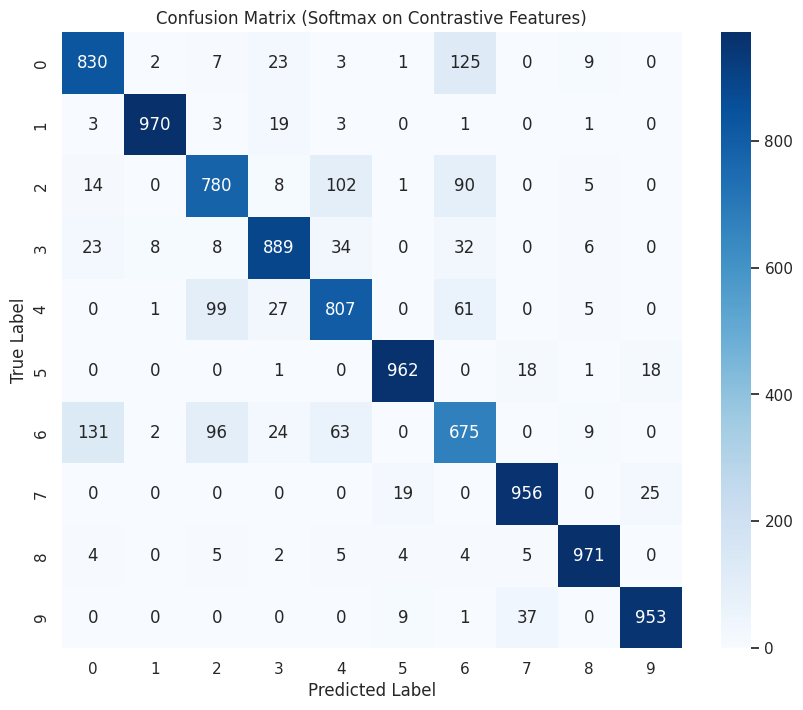

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Get true and predicted labels
y_pred = []
y_true = []

for x_batch, y_batch in test_ds:
    r = encoder(x_batch, training=False)
    logits = softmax(r, training=False)
    preds = tf.argmax(logits, axis=1).numpy()

    y_pred.extend(preds)
    y_true.extend(y_batch.numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Softmax on Contrastive Features)")
plt.show()
